In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys

lib_path = os.path.abspath("").replace("notebooks", "src")
sys.path.append(lib_path)

import torch
from sklearn import svm
from data.dataloader import build_train_test_dataset
from tqdm.auto import tqdm
from models import networks
from torch import nn
from configs.base import Config
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
def dis(a, b):
    return np.linalg.norm(a - b)

In [3]:
index2label={
    0 :'Anger',
    1 :'Happiness',
    2 :'Sadness',
    3 :'Neutral',
}
def eval(cfg, checkpoint_path, all_state_dict=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    network = getattr(networks, cfg.model_type)(cfg)
    network.to(device)

    # Build dataset
    
    train_ds, val_ds = build_train_test_dataset(cfg)
    cfg.data_valid = "test.pkl"
    _, test_ds = build_train_test_dataset(cfg)
    
    weight = torch.load(checkpoint_path, map_location=torch.device(device))
    if all_state_dict:
        weight = weight["state_dict_network"]

    network.load_state_dict(weight)
    network.eval()
    network.to(device)

    cosim_scores = {
        'Anger':[],
        'Happiness':[],
        'Sadness':[],
        'Neutral':[],
        
    }
    distance_scores = {
        'Anger':[],
        'Happiness':[],
        'Sadness':[],
        'Neutral':[],
        
    }
    for every_test_list in tqdm(train_ds):
        input_ids, audio, label = every_test_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        with torch.no_grad():
            out, fusion_embeddings, text_embeddings, audio_embeddings = network(input_ids,audio)
            cosim_scores[index2label[label.item()]].append(cos(audio_embeddings[:,0,:],text_embeddings[:,0,:]).cpu().numpy().item())
            distance_scores[index2label[label.item()]].append(dis(audio_embeddings[:,0,:].detach().cpu().numpy(),text_embeddings[:,0,:].detach().cpu().numpy()).item())
    for every_test_list in tqdm(val_ds):
        input_ids, audio, label = every_test_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        with torch.no_grad():
            out, fusion_embeddings, text_embeddings, audio_embeddings = network(input_ids,audio)
            cosim_scores[index2label[label.item()]].append(cos(audio_embeddings[:,0,:],text_embeddings[:,0,:]).cpu().numpy().item())
            distance_scores[index2label[label.item()]].append(dis(audio_embeddings[:,0,:].detach().cpu().numpy(),text_embeddings[:,0,:].detach().cpu().numpy()).item())
    for every_test_list in tqdm(test_ds):
        input_ids, audio, label = every_test_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        with torch.no_grad():
            out, fusion_embeddings, text_embeddings, audio_embeddings = network(input_ids,audio)
            cosim_scores[index2label[label.item()]].append(cos(audio_embeddings[:,0,:],text_embeddings[:,0,:]).cpu().numpy().item())
            distance_scores[index2label[label.item()]].append(dis(audio_embeddings[:,0,:].detach().cpu().numpy(),text_embeddings[:,0,:].detach().cpu().numpy()).item())
    return cosim_scores, distance_scores

In [4]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int32(window_size))
        order = np.abs(np.int32(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [5]:
ckpt_paths = {
    "Smooth Lce" : 'checkpoints_latest/IEMOCAP/_4M_SER_bert_vggish/20240324-231013',
    "Smooth Lce + Lc":'checkpoints_latest/IEMOCAP_losses/_4M_SER_CrossEntropyLoss_CenterLoss_bert_vggish/20240317-094341',
    "Smooth Lfl": 'checkpoints_latest/IEMOCAP_losses/_4M_SER_FocalLoss_bert_vggish/20240320-153009',
    "Smooth Lce + Lct-c": 'checkpoints_latest/IEMOCAP_losses/_4M_SER_CrossEntropyLoss_ContrastiveCenterLoss_bert_vggish/20240317-094356',
    "Smooth Lce + Laml (CosFace)": 'checkpoints_latest/IEMOCAP_losses/_4M_SER_CosFace_bert_vggish/20240320-152652',
    "Smooth Lce + Laml (ArcFace)": 'checkpoints_latest/IEMOCAP_losses/_4M_SER_ArcFace_bert_vggish/20240320-152614',
    
}

In [6]:
cosim_scores = {
        'Anger':{},
        'Happiness':{},
        'Sadness':{},
        'Neutral':{},
        
    }
distance_scores= {
        'Anger':{},
        'Happiness':{},
        'Sadness':{},
        'Neutral':{},
        
    }
for name, checkpoint_path in ckpt_paths.items():
    cfg_path = os.path.join(checkpoint_path, "cfg.log")
    all_state_dict = True
                    
    ckpt_path = os.path.join(
        checkpoint_path, "weights/best_acc/checkpoint_0_0.pt"
    )
    if not os.path.exists(ckpt_path):
        ckpt_path = os.path.join(
            checkpoint_path, "weights/best_acc/checkpoint_0.pth"
        )
        all_state_dict = False
    
    cfg = Config()
    cfg.load(cfg_path)
    # Change to test set
    sim_score, dis_score = eval(
        cfg,
        ckpt_path,
        all_state_dict=all_state_dict,
    )
    for key, value in sim_score.items():
        data = cosim_scores[key]
        data.update({name:value})
        
    for key, value in dis_score.items():
        data = distance_scores[key]
        data.update({name:value})

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 554/554 [00:33<00:00, 16.66it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cl

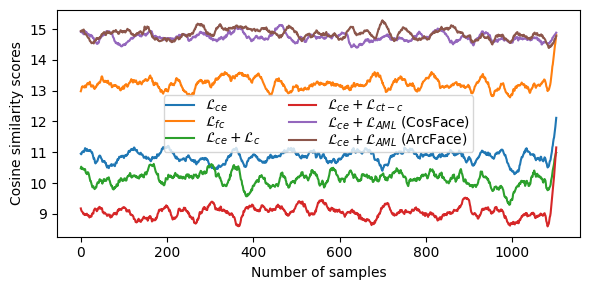

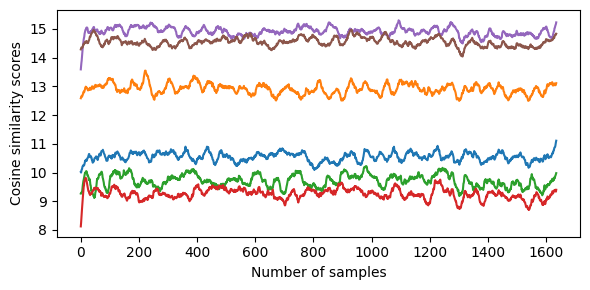

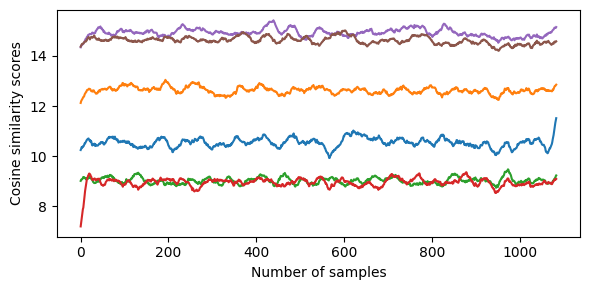

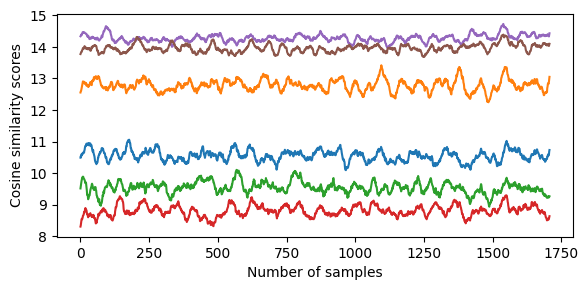

In [57]:
name2latex={
    "Smooth Lce": r"$\mathcal{L}_{ce}$",
    "Smooth Lce + Lc":r"$\mathcal{L}_{ce} + \mathcal{L}_c$",
    "Smooth Lfl" : r"$\mathcal{L}_{fc}$",
    "Smooth Lce + Lct-c" : r"$\mathcal{L}_{ce} + \mathcal{L}_{ct-c}$",
    "Smooth Lce + Laml (CosFace)":r"$\mathcal{L}_{ce} + \mathcal{L}_{AML}$ (CosFace)",
    "Smooth Lce + Laml (ArcFace)" : r"$\mathcal{L}_{ce} + \mathcal{L}_{AML}$ (ArcFace)",
    
}
legend = True
plt.rcParams["figure.figsize"] = (6,3)
for cls, sim_score in distance_scores.items():
    data_order = []
    for name, data in sim_score.items():
        data_order.append((name, data))
    temp = data_order[1]
    data_order[1] = data_order[2]
    data_order[2] = temp
    for name, data in data_order:
        name = name2latex.get(name, None)
        if name is None:
            continue
        # create data 
        y = savitzky_golay(np.array(data), 51, 3)
        x = list(range(len(y)))
        
        # plot lines 
        plt.plot(x, y, label = name) 
        # if legend:
        #     plt.yticks([i for i in range(9,21)])
        plt.ylabel("Cosine similarity scores")
        plt.xlabel("Number of samples")
    if legend:
        plt.legend(loc='center', # bbox_to_anchor=(0.5, 0.6),
          ncol=2, fancybox=True, shadow=False, borderpad=0.2, labelspacing=0)
        legend = False
    plt.tight_layout()
    plt.savefig(f"correlation_{cls}_distance.png", dpi=300, bbox_inches='tight')
    plt.show()